# Univariate Modeling of Other Campuses and Specific Sites Using the Best Found Models of Campus 5 Investigation

#### (Meant to be run within Google Colab)

In [172]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.utils import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
import random
random.seed(42)
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

In [2]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#import all campuses and sites
from google.colab import files
import io

uploaded = files.upload()

campus1 = io.BytesIO(uploaded['campus1.csv'])
camp1 = pd.read_csv(campus1)
camp1.index = pd.to_datetime(camp1['Timestamp'])

campus2 = io.BytesIO(uploaded['campus2.csv'])
camp2 = pd.read_csv(campus2)
camp2.index = pd.to_datetime(camp2['Timestamp'])

campus3 = io.BytesIO(uploaded['campus3.csv'])
camp3 = pd.read_csv(campus3)
camp3.index = pd.to_datetime(camp3['Timestamp'])

campus4 = io.BytesIO(uploaded['campus4.csv'])
camp4 = pd.read_csv(campus4)
camp4.index = pd.to_datetime(camp4['Timestamp'])

campus5 = io.BytesIO(uploaded['campus5.csv'])
camp5 = pd.read_csv(campus5)
camp5.index = pd.to_datetime(camp4['Timestamp'])

camp3_site6 = io.BytesIO(uploaded['campus3_site6.csv'])
site6 = pd.read_csv(camp3_site6)
site6.index = pd.to_datetime(site6['Timestamp'])

camp3_site8 = io.BytesIO(uploaded['campus3_site8.csv'])
site8 = pd.read_csv(camp3_site8)
site8.index = pd.to_datetime(site8['Timestamp'])

camp3_site10 = io.BytesIO(uploaded['campus3_site10.csv'])
site10 = pd.read_csv(camp3_site10)
site10.index = pd.to_datetime(site10['Timestamp'])

camp3_site12 = io.BytesIO(uploaded['campus3_site12.csv'])
site12 = pd.read_csv(camp3_site12)
site12.index = pd.to_datetime(site12['Timestamp'])

Saving campus1.csv to campus1.csv
Saving campus2.csv to campus2.csv
Saving campus3.csv to campus3.csv
Saving campus3_site6.csv to campus3_site6.csv
Saving campus3_site8.csv to campus3_site8.csv
Saving campus3_site10.csv to campus3_site10.csv
Saving campus3_site12.csv to campus3_site12.csv
Saving campus4.csv to campus4.csv
Saving campus5.csv to campus5.csv


In [3]:
camp1 = camp1[['SolarGeneration']]
camp2 = camp2[['SolarGeneration']]
camp3 = camp3[['SolarGeneration']]
camp4 = camp4[['SolarGeneration']]
camp5 = camp5[['SolarGeneration']]
site6 = site6[['SolarGeneration']]
site8 = site8[['SolarGeneration']]
site10 = site10[['SolarGeneration']]
site12 = site12[['SolarGeneration']]

In [111]:
def print_last(res):
  '''
  Helper function to just print out the last training and testing loss 
  function values as well as the last metrics of a fitted model
  '''
  print(f"Mean Absolute Error - Training: {np.round(res.history['loss'][-1], 5)}")
  print(f"Mean Absolute Error - Testing: {np.round(res.history['val_loss'][-1], 5)}")
  print(f"Root Mean Squared Error - Training: {np.round(np.sqrt(res.history['mse'][-1]), 5)}")
  print(f"Root Mean Squared Error - Testing: {np.round(np.sqrt(res.history['val_mse'][-1]), 5)}")

In [128]:
def best_model(df, model_name):
  '''
  MinMax Scaling the df, train/test splitting, and then training the best model from the previous investigation of Campus 5 on the scaled df.
  Using the previous helper function the MAE and RMSE scores are printed
  The model is then saved as an .h5 file named after the df used.
  '''

  y_train, y_test = train_test_split(df[['SolarGeneration']], shuffle = False, test_size = 0.15)
  test_ind = y_test.index

  mm = MinMaxScaler()
  y_train = mm.fit_transform(y_train)
  y_test = mm.transform(y_test)

  early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

  seq_length = 16
  train_ds = timeseries_dataset_from_array(
    y_train,
    targets = y_train[seq_length:],
    sequence_length = seq_length,
    batch_size = 96,
    shuffle = True,
    seed = 42
  )

  val_ds = timeseries_dataset_from_array(
    y_test,
    targets = y_test[seq_length:],
    sequence_length = seq_length,
    batch_size = 96,
  )

  model = Sequential()

  model.add(SimpleRNN(32, input_shape = [None,1], return_sequences = True))
  model.add(SimpleRNN(32, input_shape = [None,1]))
  model.add(Dense(1, activation = 'linear'))

  model.compile(loss = 'mae',
                optimizer = Adam(learning_rate = 0.0008), 
                metrics = ['mse'])

  res = model.fit(train_ds, 
                  validation_data = val_ds, 
                  epochs = 50, 
                  verbose = 0,
                  callbacks = [early_stop])
  model.save(f'{model_name}.h5')
  print_last(res)

  preds_df = pd.DataFrame(data = model.predict(y_test), columns = ['Preds'], index = test_ind)
  preds_df['True'] = y_test
  preds_df.to_csv(f'{model_name}_pred.csv')
  return preds_df

In [151]:
# Starts the scores array that will be the final scores dataframe
scores = [['Campus/Site', 'MAE Testing', 'RMSE Testing', 'Max Production']]

## Campus 1 (27 Individual Sites)

In [129]:
camp1_preds = best_model(camp1, 'camp1')

Mean Absolute Error - Training: 0.02673
Mean Absolute Error - Testing: 0.03372
Root Mean Squared Error - Training: 0.07127
Root Mean Squared Error - Testing: 0.08035
375/375 [==============================] - 1s 2ms/step


In [130]:
camp1.describe()

,SolarGeneration
count,79805.000000
mean,65.356255
std,111.950191
min,0.000000
25%,0.000000
50%,0.000000
75%,83.318359
max,488.087891


In [154]:
scores.append(['Campus 1', 0.03372, 0.08035, 488.088])

## Campus 2 (5 Individual Sites)

In [131]:
camp2_preds = best_model(camp2, 'camp2')

Mean Absolute Error - Training: 0.03214
Mean Absolute Error - Testing: 0.03548
Root Mean Squared Error - Training: 0.08402
Root Mean Squared Error - Testing: 0.09301
372/372 [==============================] - 1s 2ms/step


In [132]:
camp2.describe()

,SolarGeneration
count,79319.000000
mean,10.708011
std,16.009950
min,0.000000
25%,0.000000
50%,0.000000
75%,18.267578
max,57.363281


In [155]:
scores.append(['Campus 2', 0.03548, 0.09301, 57.363])

# Campus 3 (8 Individual Sites)

In [133]:
camp3_preds = best_model(camp3, 'camp3')

Mean Absolute Error - Training: 0.01925
Mean Absolute Error - Testing: 0.03617
Root Mean Squared Error - Training: 0.05659
Root Mean Squared Error - Testing: 0.09281
372/372 [==============================] - 1s 2ms/step


In [134]:
camp3.describe()

,SolarGeneration
count,79319.000000
mean,23.040234
std,42.159412
min,0.000000
25%,0.000000
50%,0.000000
75%,25.937500
max,200.214844


In [156]:
scores.append(['Campus 3', 0.03617, 0.09281, 200.215])

## Campus 4 (1 Site)

In [135]:
camp4_preds = best_model(camp4, 'camp4')

Mean Absolute Error - Training: 0.02606
Mean Absolute Error - Testing: 0.03916
Root Mean Squared Error - Training: 0.0836
Root Mean Squared Error - Testing: 0.12786
372/372 [==============================] - 1s 2ms/step


In [157]:
camp4.describe()

,SolarGeneration
count,79319.000000
mean,4.021717
std,5.999975
min,0.000000
25%,0.000000
50%,0.000000
75%,7.250000
max,21.937500


In [158]:
scores.append(['Campus 4', 0.03916, 0.12786, 21.938])

In [136]:
camp5_preds = best_model(camp5, 'camp5')

Mean Absolute Error - Training: 0.03283
Mean Absolute Error - Testing: 0.02992
Root Mean Squared Error - Training: 0.10374
Root Mean Squared Error - Testing: 0.09386
372/372 [==============================] - 1s 2ms/step


In [152]:
camp5.describe()

,SolarGeneration
count,79319.000000
mean,1.153335
std,1.799824
min,0.000000
25%,0.000000
50%,0.000000
75%,1.859375
max,6.281250


In [153]:
scores.append(['Campus 5', 0.02992, 0.09386, 6.281])

---
# Individual Sites on Campus 3 Modeled:

### Site 6

In [137]:
site6_preds = best_model(site6, 'site6')

Mean Absolute Error - Training: 0.0354
Mean Absolute Error - Testing: 0.02818
Root Mean Squared Error - Training: 0.10682
Root Mean Squared Error - Testing: 0.07417
198/198 [==============================] - 1s 2ms/step


In [138]:
site6.describe()

,SolarGeneration
count,42041.000000
mean,5.200881
std,7.994980
min,0.000000
25%,0.000000
50%,0.000000
75%,8.546875
max,28.734375


In [159]:
scores.append(['Site 6', 0.028186, 0.07417, 28.734])

### Site 8

In [139]:
site8_preds = best_model(site8, 'site8')

Mean Absolute Error - Training: 0.03821
Mean Absolute Error - Testing: 0.03348
Root Mean Squared Error - Training: 0.1143
Root Mean Squared Error - Testing: 0.0897
198/198 [==============================] - 1s 2ms/step


In [7]:
site8.describe()

,SolarGeneration
count,42041.000000
mean,4.808123
std,7.638348
min,0.000000
25%,0.000000
50%,0.000000
75%,7.453125
max,26.968750


In [160]:
scores.append(['Site 8', 0.03348, 0.0897, 26.969])

### Site 10

In [140]:
site10_preds = best_model(site10, 'site10')

Mean Absolute Error - Training: 0.03893
Mean Absolute Error - Testing: 0.03832
Root Mean Squared Error - Training: 0.10913
Root Mean Squared Error - Testing: 0.11368
372/372 [==============================] - 1s 2ms/step


In [12]:
site10.describe()

,SolarGeneration
count,79319.000000
mean,1.669451
std,2.445814
min,0.000000
25%,0.000000
50%,0.000000
75%,3.046875
max,7.750000


In [161]:
scores.append(['Site 10', 0.03832, 0.11368, 7.750])

### Site 12

In [141]:
site12_preds = best_model(site12, 'site12')

Mean Absolute Error - Training: 0.02782
Mean Absolute Error - Testing: 0.05323
Root Mean Squared Error - Training: 0.07895
Root Mean Squared Error - Testing: 0.15264
372/372 [==============================] - 1s 2ms/step


In [150]:
site12.describe()

,SolarGeneration
count,79319.000000
mean,2.827579
std,4.491140
min,0.000000
25%,0.000000
50%,0.000000
75%,4.531250
max,17.593700


In [162]:
scores.append(['Site 12', 0.05323, 0.15264, 17.594])

In [163]:
# creating the df out of the scores array
scores_df = pd.DataFrame(data = scores[1:], columns = scores[0])

In [164]:
scores_df

,Campus/Site,MAE Testing,RMSE Testing,Max Production
0,Campus 5,0.029920,0.09386,6.281
1,Campus 1,0.033720,0.08035,488.088
2,Campus 2,0.035480,0.09301,57.363
3,Campus 3,0.036170,0.09281,200.215
4,Campus 4,0.039160,0.12786,21.938
5,Site 6,0.028186,0.07417,28.734
6,Site 8,0.033480,0.08970,26.969
7,Site 10,0.038320,0.11368,7.750
8,Site 12,0.053230,0.15264,17.594


In [165]:
scores_df.to_csv('scores_df.csv')

---
## Investigating Campus 5 Predictions  

---

In [170]:
camp5_preds

,Preds,True
Timestamp,,
2021-12-21 01:30:00,0.01651,0.0
2021-12-21 01:45:00,0.01651,0.0
2021-12-21 02:00:00,0.01651,0.0
2021-12-21 02:15:00,0.01651,0.0
2021-12-21 02:30:00,0.01651,0.0
...,...,...
2022-04-23 22:45:00,0.01651,0.0
2022-04-23 23:00:00,0.01651,0.0
2022-04-23 23:15:00,0.01651,0.0


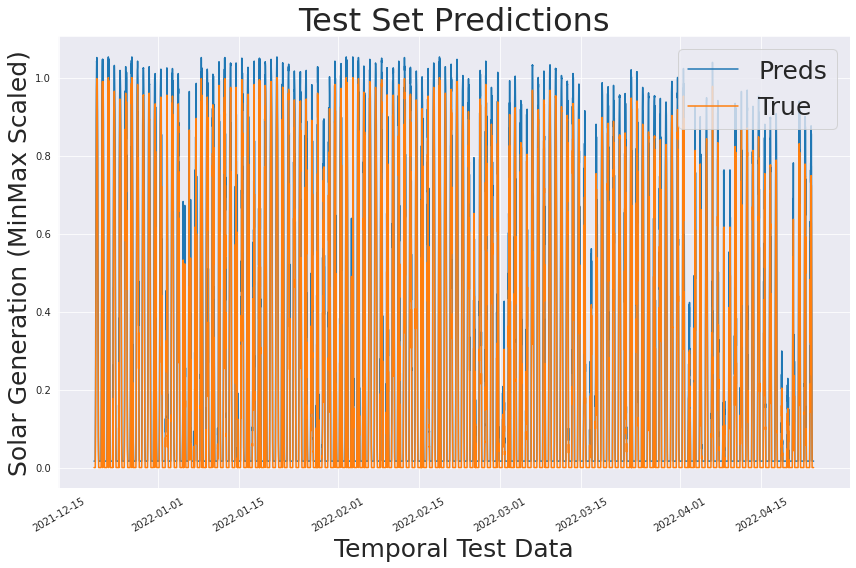

In [209]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize = (12,8))
plt.plot(camp5_preds)
ax.set_xlabel('Temporal Test Data', fontsize = 25)
for tick in ax.get_xticklabels():
    tick.set_rotation(30)
ax.set_ylabel('Solar Generation (MinMax Scaled)', fontsize = 25)
ax.set_title('Test Set Predictions', fontsize = 32)
ax.legend(['Preds', 'True'], fontsize = 25)
plt.tight_layout()
plt.savefig('campus5_preds.png');

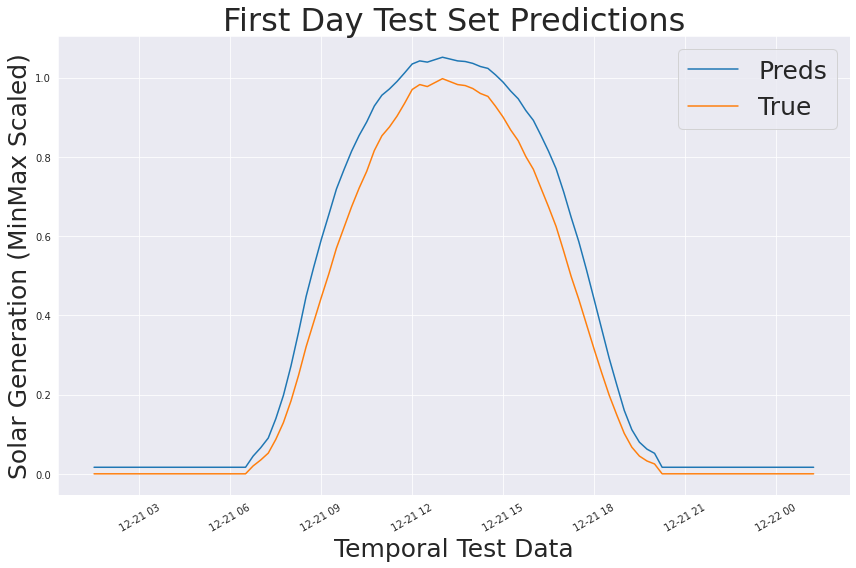

In [208]:
fig, ax = plt.subplots(figsize = (12,8))
plt.plot(camp5_preds[:96])
ax.set_xlabel('Temporal Test Data', fontsize = 25)
for tick in ax.get_xticklabels():
    tick.set_rotation(30)
ax.set_ylabel('Solar Generation (MinMax Scaled)', fontsize = 25)
ax.set_title('First Day Test Set Predictions', fontsize = 32)
ax.legend(['Preds', 'True'], fontsize = 25)
plt.tight_layout()
plt.savefig('campus5_preds_firstday.png');

In [190]:
len(camp5_preds) - 96

11802

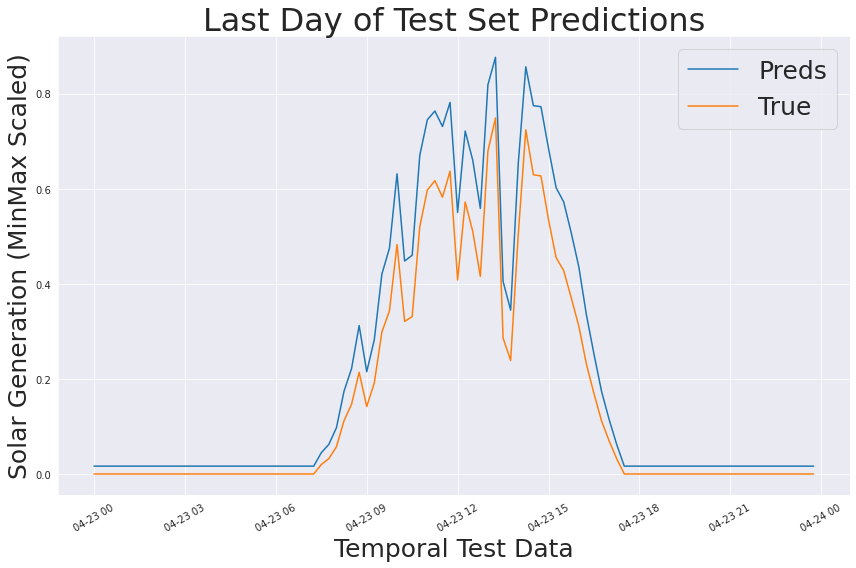

In [207]:
fig, ax = plt.subplots(figsize = (12,8))
plt.plot(camp5_preds[11802:])
ax.set_xlabel('Temporal Test Data', fontsize = 25)
for tick in ax.get_xticklabels():
    tick.set_rotation(30)
ax.set_ylabel('Solar Generation (MinMax Scaled)', fontsize = 25)
ax.set_title('Last Day of Test Set Predictions', fontsize = 32)
ax.legend(['Preds', 'True'], fontsize = 25)
plt.tight_layout()
plt.savefig('campus5_preds_lastday.png');

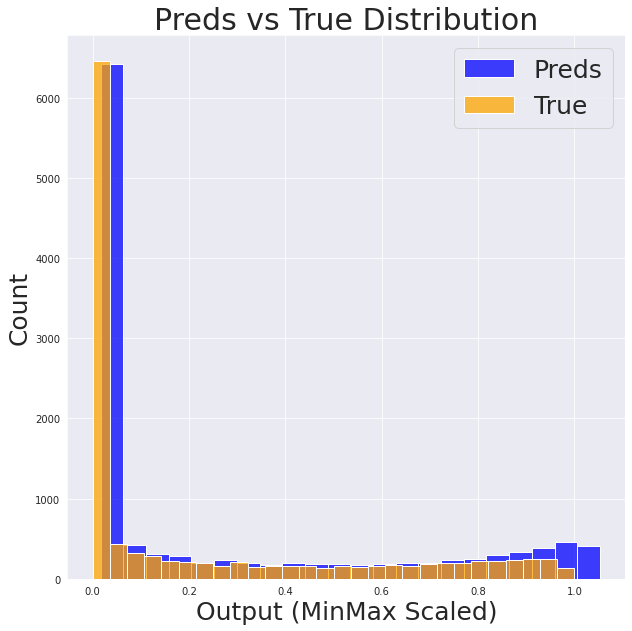

In [215]:
ax = plt.figure(figsize = (10, 10))
ax = sns.histplot(data=camp5_preds['Preds'], color="blue", label="Preds")
ax = sns.histplot(data=camp5_preds['True'], color="orange", label="True")
ax.set_xlabel('Output (MinMax Scaled)', fontsize = 25)
ax.set_ylabel('Count', fontsize = 25)
ax.set_title('Preds vs True Distribution', fontsize = 30)
ax.legend(fontsize = 25)
plt.savefig('campus5_truevspreds.png');

### Investigating Site10 to see if model does similar to Campus 5

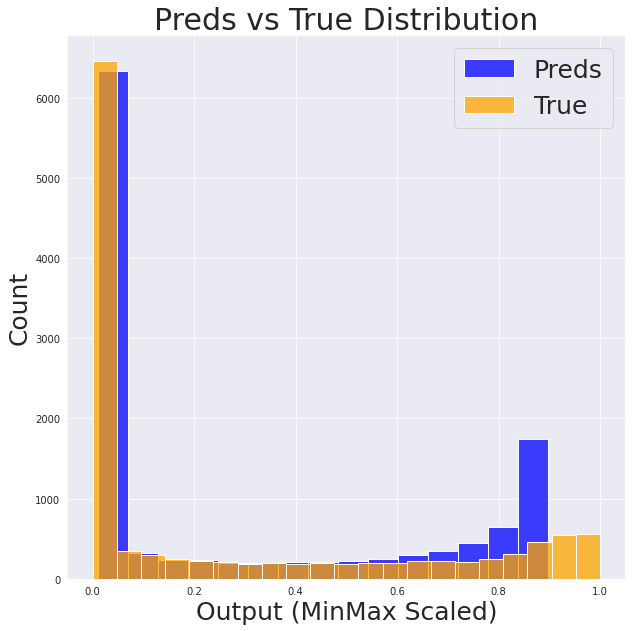

In [216]:
ax = plt.figure(figsize = (10, 10))
ax = sns.histplot(data=site10_preds['Preds'], color="blue", label="Preds")
ax = sns.histplot(data=site10_preds['True'], color="orange", label="True")
ax.set_xlabel('Output (MinMax Scaled)', fontsize = 25)
ax.set_ylabel('Count', fontsize = 25)
ax.set_title('Preds vs True Distribution', fontsize = 30)
ax.legend(fontsize = 25);
plt.savefig('site10_truevspreds.png')

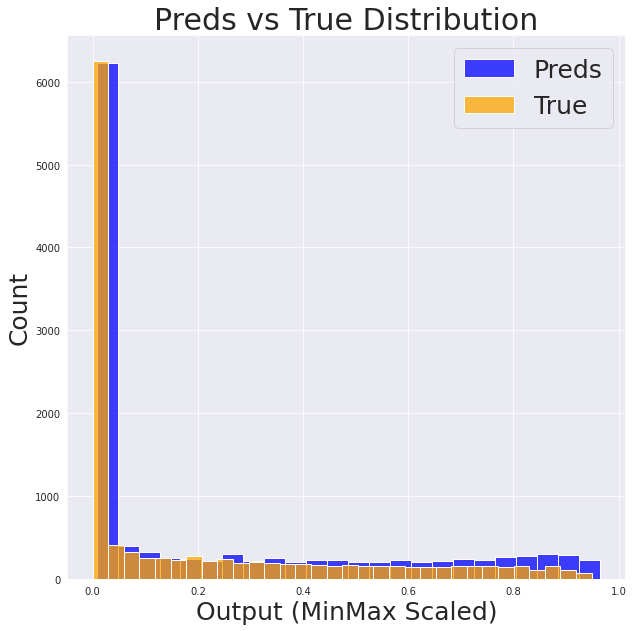

In [218]:
# Just checking another entire Campus
ax = plt.figure(figsize = (10, 10))
ax = sns.histplot(data=camp1_preds['Preds'], color="blue", label="Preds")
ax = sns.histplot(data=camp1_preds['True'], color="orange", label="True")
ax.set_xlabel('Output (MinMax Scaled)', fontsize = 25)
ax.set_ylabel('Count', fontsize = 25)
ax.set_title('Preds vs True Distribution', fontsize = 30)
ax.legend(fontsize = 25);
plt.savefig('camp1_truevspreds.png')